# Processing SAR data to TileDB arrays

Data is openly licensed from the Spacenet 6 challenge -https://medium.com/the-downlinq/spacenet-6-expanded-dataset-release-e1a7ddaf030

We will start by copying over two sample SAR intensity GeoTIFFs.

In [12]:
import os

image_1 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804111224_20190804111453.tif"
image_2 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804111851_20190804112030.tif"

if not os.path.exists(f"./tmp/{image_1}") and not os.path.exists(f"./tmp/{image_2}"):
    !aws s3 cp s3://spacenet-dataset/AOIs/AOI_11_Rotterdam/SAR-MAG-POL/$image_1 ./tmp/
    !aws s3 cp s3://spacenet-dataset/AOIs/AOI_11_Rotterdam/SAR-MAG-POL/$image_2 ./tmp/

# rename the image data files
image_1 = f"./tmp/{image_1}"
image_2 = f"./tmp/{image_2}"

In [13]:
import json
from matplotlib import pyplot
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rasterio.crs import CRS
import shutil

output_array = "arrays/sar_output_array"

# clean up previous runs
try:
    shutil.rmtree(output_array)
except:
    pass

Inspect the bounds

In [14]:
!rio info $image_1 | jq .
!rio info $image_2 | jq .

{
  "bounds": [
    592317.4837528648,
    5749199.061398174,
    602998.4837528648,
    5749906.311398174
  ],
  "colorinterp": [
    "gray",
    "undefined",
    "undefined",
    "undefined",
    "undefined",
    "undefined"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "GTiff",
  "dtype": "float32",
  "height": 2829,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "pixel",
  "lnglat": [
    4.419039098958206,
    51.888177188743526
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    0.25,
    0.25
  ],
  "shape": [
    2829,
    42724
  ],
  "tiled": false,
  "transform": [
    0.25,
    0,
    592317.4837528648,
    0,
    -0.25,
    5749906.311398174,
    0,
    0,
    1
  ],
  "units": [


We will mosaic the input GeoTIFF images

In [16]:
!gdalbuildvrt mosaic.vrt ./tmp/SN6*.tif
!gdal_translate -OF TileDB -CO BLOCKXSIZE=1024 -CO BLOCKYSIZE=1024 -CO COMPRESSION=ZSTD -CO COMPRESSION_LEVEL=7 mosaic.vrt $output_array

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 45364, 14938
0...10...20...30...40...50...60...70...80...90...100 - done.


And inspect the output again

In [17]:
!rio info $output_array | jq .

{
  "blockxsize": 1024,
  "blockysize": 1024,
  "bounds": [
    592317.4837528648,
    5746171.811398174,
    603658.4837528648,
    5749906.311398174
  ],
  "colorinterp": [
    "red",
    "green",
    "blue",
    "alpha",
    "alpha",
    "alpha"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "TileDB",
  "dtype": "float32",
  "height": 14938,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "band",
  "lnglat": [
    4.423402818720698,
    51.8745142675512
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    0.25,
    0.25
  ],
  "shape": [
    14938,
    45364
  ],
  "tiled": true,
  "transform": [
    0.25,
    0,
    592317.4837528648,
    0,
    -0.25,
    5749906.311398174,
    0,
    0,
   

Finally we will slice an AOI from the TileDB array using Rasterio and display

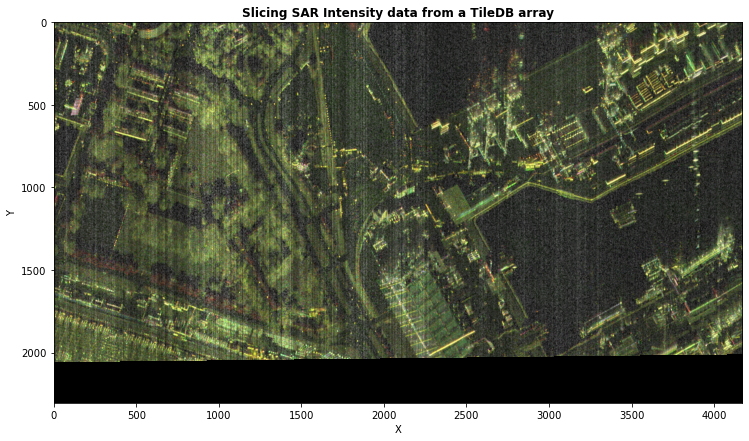

In [18]:
from rasterio.plot import reshape_as_raster, reshape_as_image, adjust_band

with rasterio.Env():
    with rasterio.open(output_array) as src:
        # query dataset in lat/lon coordinates
        bbox = [4.42, 51.885, 4.435, 51.89]
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

        # The georeferenced MAG-POL data has a base resolution of 0.25m and contains 4 channels of SAR magnitude (intensity)
        # (1: HH , 2: HV, 3: VH, 4: VV) as well as 2 channels (5: alpha² & 6: beta²)
        # (Red = HH Intensity, Green = VV Intensity, Blue = HV Intensity)
        img = src.read((1, 4, 2), window=bounds_window)
        fig, ax = pyplot.subplots(1, 1, figsize=(21,7))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        arr = reshape_as_raster(img)
        for b, band in enumerate(arr):
            arr[b] = adjust_band(band)
        arr = reshape_as_image(arr)        
        
        show(arr, ax=ax, title="Slicing SAR Intensity data from a TileDB array")